# Debut

In [7]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
from functions.simulation import get_dataset, ABC_epsilon, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative, post_pdf_z
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return (jnp.mean(y) - jnp.mean(y_true))**2

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


In [ ]:
key = random.PRNGKey(0)
 
MU0 = 0.
SIGMA = 1.
MODEL_ARGS = [SIGMA]
N_DATA = 10
N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000
N_POINTS_EPS = 10000
sim_args = None


N_EPOCHS = 1
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000
L = 63
B = 16
N_SBC = (L+1)*1

PATH_RESULTS = os.getcwd() + "/examples/Gauss-Gauss/paper_results/"
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
    

N_DATAS = [5, 10, 50, 100]
SIGMAS0 = [2*SIGMA, 5*SIGMA, 10*SIGMA, 20*SIGMA]
ACCEPT_RATES = [1., .999, .99, .975, .95, .925, .9, .85, .8, .75]



for N_DATA in N_DATAS:
    PATH_N_DATA = PATH_RESULTS+ "N_data_{}/".format(N_DATA)
    if not os.path.exists(PATH_N_DATA):
        os.makedirs(PATH_N_DATA)
    
    for SIGMA0 in SIGMAS0:
        PATH_SIGMA0 = PATH_N_DATA+ "sigma0_{}/".format(SIGMA0)
        if not os.path.exists(PATH_SIGMA0):
            os.makedirs(PATH_SIGMA0)
            
        TRUE_MUS = [.1*SIGMA0, .5*SIGMA0, SIGMA0, 1.5*SIGMA0]
        PRIOR_ARGS = [MU0, SIGMA0]
        PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
        MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
        
        for TRUE_MU in TRUE_MUS:
            PATH_TRUE_MU = PATH_SIGMA0 + "mu_{}/".format(TRUE_MU)
            if not os.path.exists(PATH_TRUE_MU):
                os.makedirs(PATH_TRUE_MU)
            EPSILON_STAR = jnp.inf
            key, subkey = random.split(key)
            TRUE_DATA = data_simulator(subkey, TRUE_MU)
            for ACCEPT_RATE in ACCEPT_RATES:
                print("\n\n--------------------")
                print("SIGMA0 = {}, TRUE_MU = {}, ACCEPT_RATE = {}".format(SIGMA0, TRUE_MU, ACCEPT_RATE))
                print("--------------------\n\n")
                        
                
                time_eps = time.time()
                print("Selection of epsilon star...")
                EPSILON_STAR, key = get_epsilon_star(key, ACCEPT_RATE, N_POINTS_EPS, prior_simulator, data_simulator, discrepancy, TRUE_DATA, quantile_rate = .99, epsilon = EPSILON_STAR)
                print('Time to select epsilon star: {:.2f}s\n'.format(time.time()-time_eps))

                print("Simulations of the testing dataset...")
                time_sim = time.time()
                X_test, y_test, key = get_dataset(key, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
                print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))

                print("Simulations of the training dataset...")
                time_sim = time.time()
                X_train, y_train, key = get_dataset(key, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
                print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))


                print("Training the neural network...")
                time_nn = time.time()
                params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
                print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))


                # print("Simulation Based Calibration...")
                # time_sbc = time.time()

                # ranks, thetas_tilde, thetas, key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = params, epsilon = EPSILON_STAR, true_data = TRUE_DATA, prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = N_GRID_EXPLO, n_grid_final = N_GRID_FINAL, minn = MINN, maxx = MAXX)

                # print('Time to perform SBC: {:.2f}s\n'.format(time.time()-time_sbc))


                pickle_dico = {"ACCEPT_RATE":ACCEPT_RATE, "epsilon":EPSILON_STAR, "KEY":key, "N_SBC":N_SBC, "L":L, "N_GRID_EXPLO": N_GRID_EXPLO, 'N_GRID_FINAL': N_GRID_FINAL,"TRUE_DATA": TRUE_DATA, "TRUE_THETA": TRUE_MU, "params": params, "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "MODEL_ARGS":MODEL_ARGS, "PRIOR_ARGS":PRIOR_ARGS, "N_POINTS_TRAIN":N_POINTS_TRAIN, "N_POINTS_TEST":N_POINTS_TEST, "N_DATA":N_DATA, "N_EPOCHS":N_EPOCHS, "LEARNING_RATE":LEARNING_RATE, "PATIENCE":PATIENCE, "COOLDOWN":COOLDOWN, "FACTOR":FACTOR, "RTOL":RTOL, "ACCUMULATION_SIZE":ACCUMULATION_SIZE, "LEARNING_RATE_MIN":LEARNING_RATE_MIN, "BATCH_SIZE":BATCH_SIZE, "NUM_BATCH":NUM_BATCH, "NUM_CLASSES":NUM_CLASSES, "HIDDEN_SIZE":HIDDEN_SIZE, "NUM_LAYERS":NUM_LAYERS, "WDECAY":WDECAY}
                          #  "ranks": ranks, "thetas_tilde": thetas_tilde, "thetas": thetas}



                NAME = "GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}_ndata_{}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR, N_DATA)
                NAMEFIG = PATH_TRUE_MU+'figures/'+NAME+".png"
                NAMEFILE = PATH_TRUE_MU+'pickles/'+NAME+".xy"
                
                if not os.path.exists(PATH_TRUE_MU+'figures/'):
                    os.makedirs(PATH_TRUE_MU+'figures/')
                if not os.path.exists(PATH_TRUE_MU+'pickles/'):
                    os.makedirs(PATH_TRUE_MU+'pickles/')
                    
                
                with lzma.open(NAMEFILE, "wb") as f:
                    pickle.dump(pickle_dico, f)
                print("Data saved in ", NAMEFILE)

                title = "Normal w/ known std\nsigma = {}, sigma0 = {} mu = {}\nalpha = {:.2%}, eps = {:.3} accuracy = {:.2%}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR, test_accuracy[-1])
        
                
                f, ax = plt.subplots(1,3, figsize = (15,5))
                sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
                sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])

                ax[0].legend()
                f.suptitle(f'GaussGauss with sigma = {SIGMA} sigma0 = {SIGMA0} mu = {TRUE_MU} alpha = {ACCEPT_RATE:.1%}, epsilon = {EPSILON_STAR:.3} accuracy = {test_accuracy[-1]:.2%}')

                grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
                grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
                
                Z_approx = np.trapz(pdf_approx, grid_approx)
                ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
                ax[1].plot(grid_true, pdf_true, label = "True")
                ax[1].legend()
                ax[1].set_title("Posterior comparison of the true data")
                plot_SBC(ranks, L, B, ax = ax[2])
                ax[2].set_title("SBC with Rank Statistics")
                f.savefig(NAMEFIG)
                plt.close(f)
                
                
                
                
                
                print("\n\n--------------------")
                print("ITERATION (ACC = {}) DONE IN {} SECONDS!".format(ACCEPT_RATE, time.time()-time_eps))
                print("--------------------\n\n")



--------------------
SIGMA0 = 2.0, TRUE_MU = 0.2, ACCEPT_RATE = 1.0
--------------------


Selection of epsilon star...
Distances: min =  4.6307256e-09 max =  59.224213 mean =  4.238362 std =  5.8794403
Time to select epsilon star: 0.05s

Simulations of the testing dataset...
Time to simulate the testing dataset: 0.22s

Simulations of the training dataset...
Time to simulate the training dataset: 3.25s

Training the neural network...


KeyboardInterrupt: 

In [ ]:
import os
import lzma
import pickle

# Directory containing the pickle files
directory = PATH_RESULTS+"/pickle"

# List to store the data from each pickle file
data_list = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".xy"):
        filepath = os.path.join(directory, filename)
        with lzma.open(filepath, "rb") as f:
            data = pickle.load(f)
            data_list.append(data)

# Print the number of files read
print(f"Number of files read: {len(data_list)}")
key = data_list[0]["KEY"]
L = 15
N_SBC = (L+1)*100
for data in data_list: 
    data["ranks"], data["thetas_tilde"], data["thetas"], key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = data["params"], epsilon = data["epsilon"], true_data = data["TRUE_DATA"], prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = data["N_GRID_EXPLO"], n_grid_final = data["N_GRID_FINAL"], minn = MINN, maxx = MAXX)
    

Number of files read: 10


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

In [32]:
from functions.SBC import post_pdf_z, find_grid_explorative
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

L = 15
B = 8
for ACCEPT_RATE in np.sort(ACCEPT_RATES)[::-1]:
    data = dico[ACCEPT_RATE]
    ranks = data["ranks"]
    thetas_tilde = data["thetas_tilde"]
    thetas = data["thetas"]
    epsilon = data["epsilon"]
    TRUE_DATA = data["TRUE_DATA"]
    TRUE_THETA = data["TRUE_THETA"]
    params = data["params"]
    train_accuracy = data["train_accuracy"]
    test_accuracy = data["test_accuracy"]
    MODEL_ARGS = data["MODEL_ARGS"]
    PRIOR_ARGS = data["PRIOR_ARGS"]
    N_POINTS_TRAIN = data["N_POINTS_TRAIN"]
    N_POINTS_TEST = data["N_POINTS_TEST"]
    N_DATA = data["N_DATA"]
    N_EPOCHS = data["N_EPOCHS"]
    LEARNING_RATE = data["LEARNING_RATE"]
    PATIENCE = data["PATIENCE"]
    COOLDOWN = data["COOLDOWN"]
    FACTOR = data["FACTOR"]
    RTOL = data["RTOL"]
    ACCUMULATION_SIZE = data["ACCUMULATION_SIZE"]
    LEARNING_RATE_MIN = data["LEARNING_RATE_MIN"]
    BATCH_SIZE = data["BATCH_SIZE"]
    NUM_BATCH = data["NUM_BATCH"]
    NUM_CLASSES = data["NUM_CLASSES"]
    HIDDEN_SIZE = data["HIDDEN_SIZE"]
    NUM_LAYERS = data["NUM_LAYERS"]
    WDECAY = data["WDECAY"]
    TRUE_MU = TRUE_THETA
    EPSILON_STAR = epsilon
    NAMEFILE = PATH_RESULTS+"pickle/GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR)
    NAMEFIG = PATH_RESULTS+"figures/GaussGauss_sigma_{}_sigma0_{}_mu_{}_acc_{:.3}_eps_{:.5}".format(SIGMA, SIGMA0, TRUE_MU, ACCEPT_RATE, EPSILON_STAR)
    MU0 = PRIOR_ARGS[0]
    SIGMA0 = PRIOR_ARGS[1]
    PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
    
    SIGMA = MODEL_ARGS[0]
    accuracy = test_accuracy[-1]
    
    f, ax = plt.subplots(1,3, figsize = (15,5))
    sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
    sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])
    
    ax[0].legend()
    f.suptitle(f'Norm accept = {ACCEPT_RATE:.1%}, epsilon = {EPSILON_STAR:.3} accuracy = {accuracy:.2%}')
    
    grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, MINN, MAXX)
    Z_approx = np.trapz(pdf_approx, grid_approx)
    ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx")
    ax[1].plot(grid_true, pdf_true, label = "True")
    ax[1].legend()
    ax[1].set_title("Posterior comparison of the true data")
    plot_SBC(ranks, L, B, ax = ax[2])
    ax[2].set_title("SBC with Rank Statistics")
    print(NAMEFIG)
    f.savefig(NAMEFIG+".png")
    plt.close(f)
    
    
    

NameError: name 'dico' is not defined

In [ ]:
def MAP_diff_epsilon(key, N_SBC, L, params, epsilon, true_data, prior_simulator, prior_logpdf, data_simulator, discrepancy, n_grid_explo = 100, n_grid_final = 1000, minn = -50, maxx = 50, X = np.array([])):
    if len(X) == 0:
        datas, thetas_tilde, _, key = ABC_epsilon(key, N_SBC, prior_simulator, data_simulator, discrepancy, epsilon, true_data)
    else:
        key, key_ = random.split(key)
        dim_theta = prior_simulator(key_).shape[0]
        datas = X[:, dim_theta:]
        thetas_tilde = X[:, :dim_theta].reshape(-1, dim_theta)
        N_SBC = len(datas)
    ranks = jnp.zeros(N_SBC)
    grids, pdf_values = jnp.zeros((N_SBC, n_grid_final)), jnp.zeros((N_SBC, n_grid_final))
    thetas = jnp.zeros((N_SBC, L))
    for i in tqdm(range(N_SBC), mininterval= N_SBC//20):
        grid, pdf_value = find_grid_explorative(lambda x: post_pdf_z(params, x, datas[i], prior_logpdf), n_grid_explo, n_grid_final, minn, maxx)
        grids = grids.at[i].set(grid)
        pdf_values = pdf_values.at[i].set(pdf_value)
    thetas, key = post_sample_batch(key, grids, pdf_values, L)
    ranks = jnp.sum(thetas < thetas_tilde, axis = 1)
    return ranks, thetas_tilde, thetas, key

In [76]:
stats.norm.cdf(1)

0.8413447460685429

# Test KDE

In [104]:
from functions.SBC import logratio_z, logratio_batch_z, post_pdf_z, find_grid_explorative
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

def true_ratio_z(mus, z, prior, posterior):
    return posterior(z).pdf(mus)/prior.pdf(mus)

def true_decision_z(mus, z, prior, posterior):
    return 1/(1+1/true_ratio_z(mus, z, prior, posterior))

def true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior):
    pseudo = true_pseudo_post(mus, bar_xobs, epsilon, prior)
    Z_pseudo = np.trapz(pseudo, mus)
    return posterior(z).pdf(mus)/pseudo*Z_pseudo

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def true_pseudo_post(mus, bar_xobs, epsilon, prior):
    return prior.pdf(mus)*(norm.cdf(bar_xobs+np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)) - norm.cdf(bar_xobs-np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)))

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def decision_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_z(params, mus, z)))
def decision_batch_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_batch_z(params, mus, z)))

def ABC_gauss_single(key, true_data, epsilon):
    key, key_xbar = random.split(key)
    xbar = random.truncated_normal(key_xbar, lower = (jnp.mean(true_data)-jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)), upper = (jnp.mean(true_data)+jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)))*jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)) + MU0
    dist = (jnp.mean(true_data)-xbar)**2
    key, key_z = random.split(key)
    z = random.normal(key_z, (len(true_data),))*SIGMA
    z = z-jnp.mean(z)+xbar
    key, key_mu = random.split(key)
    mu = random.normal(key_mu, (1,))*SIGMA/jnp.sqrt(len(true_data)) + xbar
    return z, mu, dist


def ABC_gauss(key, true_data, epsilon, N_ABC):
    keys = random.split(key, N_ABC+1)
    zs, mus, dists = vmap(jit(ABC_gauss_single), (0, None, None))(keys[1:], true_data, epsilon)
    return zs, mus, dists, keys[0]

def get_epsilon_star_gauss(key, acceptance_rate, n_points, prior_simulator, data_simulator, discrepancy, true_data, quantile_rate = .9, epsilon = jnp.inf, return_accept = False):
    new_epsilon = epsilon
    accept = 1.
    
    datas, thetas, dists, key = ABC_gauss(key, true_data, epsilon, n_points)
    if epsilon == jnp.inf:
        print("Distances: min = ", jnp.min(dists), "max = ", jnp.max(dists), "mean = ", jnp.mean(dists), "std = ", jnp.std(dists))
    while accept > acceptance_rate:
        epsilon = new_epsilon
        new_epsilon = float(jnp.quantile(dists, quantile_rate))
        datas, thetas, dists, key = ABC_gauss(key, true_data, new_epsilon, n_points)
        key, subkey = random.split(key)
        keys_pred = random.split(subkey, n_points)
        datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, thetas)
        new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, true_data)
        accept = jnp.mean(new_dists < new_epsilon)
        epsilon = new_epsilon
        print("epsilon: ", epsilon, "acceptance rate: ", accept)
    if return_accept: 
        return epsilon, accept, key
    return epsilon, key

def get_dataset_gauss(key, n_points, prior_simulator, data_simulator, discrepancy, epsilon, true_data):
    n_points = n_points//2
    zs0, thetas0, _, key = ABC_gauss(key, true_data, epsilon, n_points)
    _, thetas1, _, key = ABC_gauss(key, true_data, epsilon, n_points)    
    zs = jnp.concatenate([zs0, zs0], axis=0)
    thetas = jnp.concatenate([thetas0, thetas1], axis=0)
    ys = jnp.append(jnp.zeros(n_points), jnp.ones(n_points)).astype(int)
    Xs = jnp.concatenate([thetas, zs], axis=1)
    return Xs, ys, key

Ici on compare: 
- ABC-NRE with KDE: $\hat r(x,\theta) \cdot \hat \pi_\epsilon(\theta \mid x_{obs})$
- ABC-NRE without KDE: $\hat r(x,\theta) \cdot \pi(\theta )\\$
à la true posterior $\pi(\theta\mid x_{obs})$ et à la pseudo-posterior $\pi_\epsilon(\theta\mid x_{obs})$

Il semble que le $r(x, \theta) >> \pi_\epsilon(\theta\mid x_{obs})$ donc qu'utiliser $\pi_\epsilon(\theta\mid x_{obs})$ ou $\pi(\theta)$ ne change rien... On essaie de reduire $n = 5$. 


Comme
$$\pi(\theta\mid x) = r(x, \theta) \cdot \pi(\theta)$$ 
on a 
$$r(x, \theta) = \frac{\pi(\theta \mid x)}{\pi(\theta)} = \frac{f(x\mid \theta)}{p(x)}$$
Ca serait bien d'essayer de calculer analytiquement $p(x)$ pour exprimer 
$$ f(x\mid \theta) = r(x, \theta)\cdot p(x)$$

# On the choice on $\epsilon$


In [6]:
SIGMA0 = 1
SIGMA = 10
N_ABC = 1000000
MU0 = 0
N_DATA = 10
TRUE_DATA = stats.norm.rvs(scale = SIGMA, size = N_DATA)
key = random.PRNGKey(0)
datas, thetas, dists, key = ABC_epsilon(key, N_ABC, prior_simulator, data_simulator, discrepancy, jnp.inf, TRUE_DATA)
index = jnp.argsort(dists)
datas, thetas, dists = datas[index], thetas[index], dists[index]

TypeError: body_fun output and input must have identical types, got
('ShapedArray(uint32[2])', 'DIFFERENT ShapedArray(float32[100]) vs. ShapedArray(float32[10])', 'ShapedArray(float32[1])', 'ShapedArray(float32[])').

## alpha

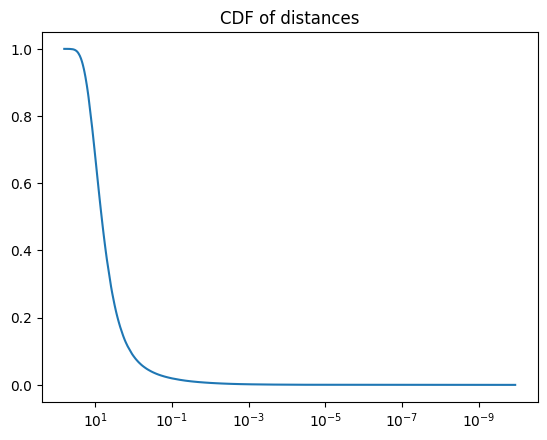

In [9]:
# plot the plot of cdf of dists with interpolation
plt.plot(dists, jnp.linspace(0,1, len(dists)))
plt.title("CDF of distances")
plt.gca().invert_xaxis()
plt.xscale("log")

## beta

In [10]:
p = [1.,.95,.9,.8,.7,.5,.25,.1,.09,.08,.07,.06,.05,.04,.03,.02,.01, .005, .001,.0009,.0005]
epsilons = np.quantile(dists, p)
N_ABC = 1000
betas =[]
for epsilon in epsilons:
    new_datas, new_thetas, new_dists, key = ABC_epsilon(key, N_ABC, prior_simulator, data_simulator, discrepancy, epsilon, TRUE_DATA)
    key, subkey = random.split(key)
    keys_pred = random.split(subkey, N_ABC)
    datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, new_thetas.reshape(-1,1))
    new_new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, TRUE_DATA)
    beta = jnp.mean(new_new_dists < epsilon)
    betas.append(beta)
    print(f"beta for epsilon = {epsilon:.2} is {beta:.2}")
    


beta for epsilon = 6.4e+01 is 1.0
beta for epsilon = 2.1e+01 is 0.97
beta for epsilon = 1.7e+01 is 0.94
beta for epsilon = 1.3e+01 is 0.89
beta for epsilon = 1e+01 is 0.83
beta for epsilon = 6.8 is 0.77
beta for epsilon = 3.3 is 0.59
beta for epsilon = 1.2 is 0.46
beta for epsilon = 1.1 is 0.46
beta for epsilon = 0.92 is 0.42
beta for epsilon = 0.78 is 0.41
beta for epsilon = 0.63 is 0.39
beta for epsilon = 0.49 is 0.37
beta for epsilon = 0.35 is 0.31
beta for epsilon = 0.22 is 0.27
beta for epsilon = 0.11 is 0.2
beta for epsilon = 0.029 is 0.12
beta for epsilon = 0.0073 is 0.044
beta for epsilon = 0.00032 is 0.01
beta for epsilon = 0.00025 is 0.008
beta for epsilon = 6.4e-05 is 0.003


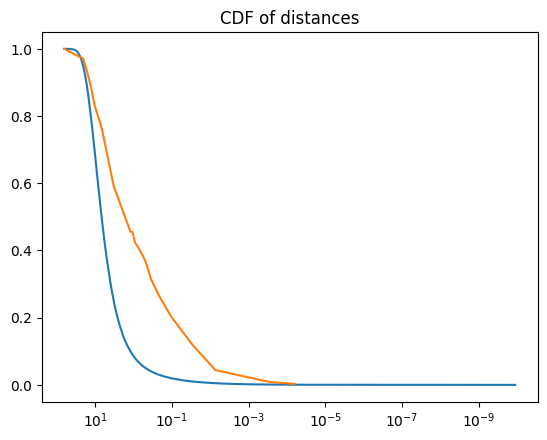

In [11]:
plt.plot(dists, jnp.linspace(0,1, len(dists)))
# plt.plot(np.interp(np.linspace(0,1, len(dists)), epsilons, betas), np.linspace(0,1, len(dists)))
plt.plot(epsilons, betas)
plt.title("CDF of distances")
plt.gca().invert_xaxis()
plt.xscale("log")

In [59]:
N_DATA = 10
SIGMA =1
MU0 = 0.
SIGMA0 = 10.
EPSILON = 10. 
TRUE_DATA = stats.norm.rvs(size = N_DATA, scale = SIGMA)
key = random.PRNGKey(0)
mus, zs, key = ABC_gauss(key, TRUE_DATA, EPSILON, 1000000)

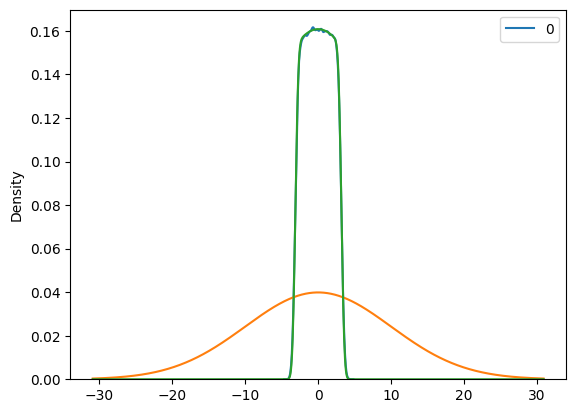

In [62]:
import seaborn as sns
sns.kdeplot(mus, label = "Mus")
grid = np.linspace(stats.norm(MU0, SIGMA0).ppf(0.001), stats.norm(MU0, SIGMA0).ppf(0.999), 1000)
plt.plot(grid, stats.norm(MU0, SIGMA0).pdf(grid), label = "Prior")
true_postt = true_pseudo_post(grid, np.mean(TRUE_DATA), EPSILON, stats.norm(MU0, SIGMA0))
plt.plot(grid, true_postt/np.trapz(true_postt,grid), label = "True Pseudo Posterior")

# New approach


In [ ]:
key = random.PRNGKey(0)
SIGMA0 = 10.
MU0 = 0.
SIGMA = 1.
TRUE_MU = 3*SIGMA0
N_DATA = 10
MODEL_ARGS = [SIGMA]
PRIOR_ARGS = [MU0, SIGMA0]

key, subkey = random.split(key)
TRUE_DATA = random.normal(subkey, (N_DATA,))*SIGMA + TRUE_MU

PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)

zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, 1000, 1000000)
# ALPHAS = [.99,.9,.75,.5,.1,.01]
# ALPHAS = [.05, .025,.0075, .005,.001]
# EPSILONS2 = {1.: jnp.inf}
# for alpha in ALPHAS: 
#     EPSILONS2[alpha] = jnp.quantile(dists, alpha)


In [122]:
len(list(EPSILONS.keys()))

12

In [133]:
ALPHAS = np.array(list(EPSILONS.keys()))

In [134]:
ALPHAS

array([1.    , 0.99  , 0.9   , 0.75  , 0.5   , 0.1   , 0.01  , 0.05  ,
       0.025 , 0.0075, 0.005 , 0.001 ])

----------------------
ALPHA = 1.0 EPSILON = 1e+03
----------------------
Simulations of the testing dataset...
Test check: True
Time to simulate the testing dataset: 0.11s

Simulations of the training dataset...
Train check: True
Time to simulate the training dataset: 0.44s

Training the neural network...
Initial accuracy: 50.16%, Initial test accuracy: 50.00%
Training for 100 epochs...
Epoch 1/100, mean train accuracy: 91.41%, mean test accuracy: 93.39%, lr scale: 1.0 in 10.49 sec
Epoch 2/100, mean train accuracy: 93.05%, mean test accuracy: 93.25%, lr scale: 1.0 in 9.15 sec
Epoch 3/100, mean train accuracy: 93.15%, mean test accuracy: 93.46%, lr scale: 1.0 in 9.35 sec
Epoch 4/100, mean train accuracy: 93.19%, mean test accuracy: 93.35%, lr scale: 1.0 in 9.38 sec
Epoch 5/100, mean train accuracy: 93.25%, mean test accuracy: 93.45%, lr scale: 1.0 in 8.73 sec
Epoch 6/100, mean train accuracy: 93.32%, mean test accuracy: 93.62%, lr scale: 0.5 in 9.06 sec
Epoch 7/100, mean train accuracy

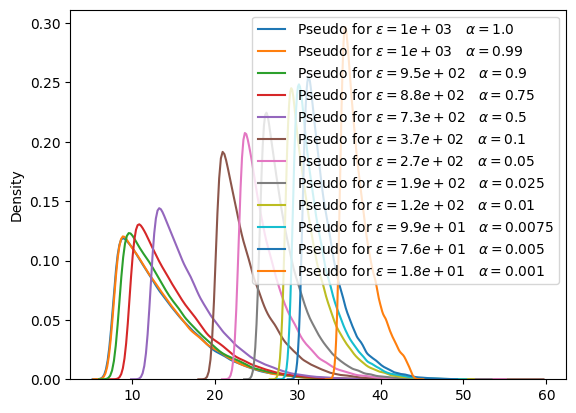

In [136]:
key = random.PRNGKey(0)


N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000
N_POINTS_EPS = 1000


N_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000




PARAMS2 = {}
TEST_ACCURACY2 = {}
for alpha in np.sort(ALPHAS)[::-1]:
    EPSILON_STAR = EPSILONS2[alpha]
    print(f"----------------------\nALPHA = {alpha} EPSILON = {EPSILON_STAR:.2}\n----------------------")


    print("Simulations of the testing dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_test, y_test, key = get_dataset_gauss(subkey, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print("Test check:", np.any(X_test[:,0]!=np.sort(X_test[:,0])))
    print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))


    print("Simulations of the training dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_train, y_train, key = get_dataset_gauss(subkey, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print("Train check:", np.any(X_train[:,0]!=np.sort(X_train[:,0])))
    print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))
    
    print("Training the neural network...")
    time_nn = time.time()
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
    print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))

    PARAMS2[alpha] = params
    TEST_ACCURACY2[alpha] = test_accuracy[-1]
    sns.kdeplot(X_test[:,0].reshape(-1), label = f"Pseudo for $\epsilon = {EPSILON_STAR:.2}\quad \\alpha = {alpha:.2}$")
plt.legend()
plt.show()



## Display 

In [13]:
TRUE_DATA.mean(),TRUE_MU

(Array(99.36851, dtype=float32), 100.0)

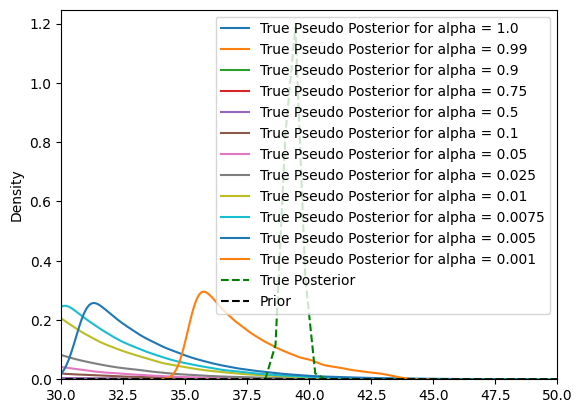

In [140]:
for alpha in np.sort(list(EPSILONS2.keys()))[::-1]:
    zs, mus, dists, key = ABC_gauss(key, TRUE_DATA2, EPSILONS2[alpha], 100000)
    sns.kdeplot(mus.reshape(-1), label = f"True Pseudo Posterior for alpha = {alpha:.2}")
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA2).pdf(x), label = "True Posterior", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "Prior", linestyle = "--", color = "black")
plt.legend()
plt.xlim(TRUE_MU2-10, TRUE_MU2+10)
plt.show()

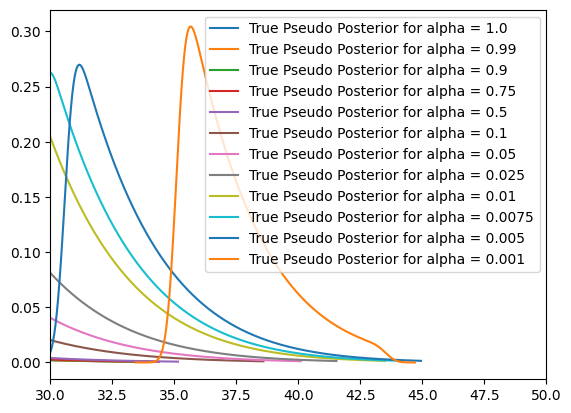

In [142]:
prior = stats.norm(loc = MU0, scale = SIGMA0)
for alpha in np.sort(list(EPSILONS2.keys()))[::-1]:
    EPSILON_STAR = EPSILONS2[alpha]
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA2), EPSILON_STAR, prior), 1000, 1000, MINN, MAXX)
    plt.plot(grid_pseudo, pdf_pseudo/np.trapz(pdf_pseudo, grid_pseudo), label = f"True Pseudo Posterior for alpha = {alpha:.2}")
    
plt.legend()
plt.xlim(TRUE_MU2-10, TRUE_MU2+10)
plt.show()

In [23]:
MINN, MAXX

(Array(-213.24454, dtype=float32), Array(213.24454, dtype=float32))

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


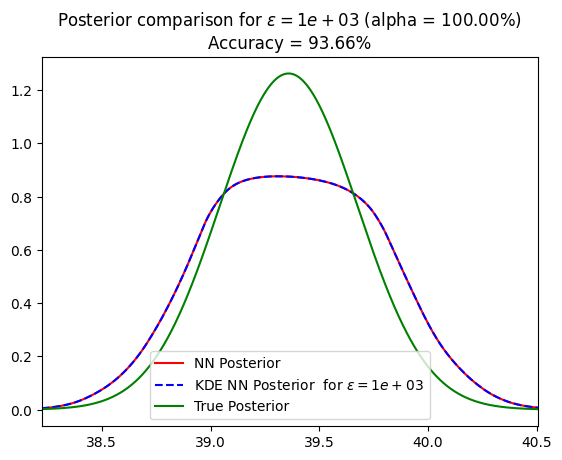

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


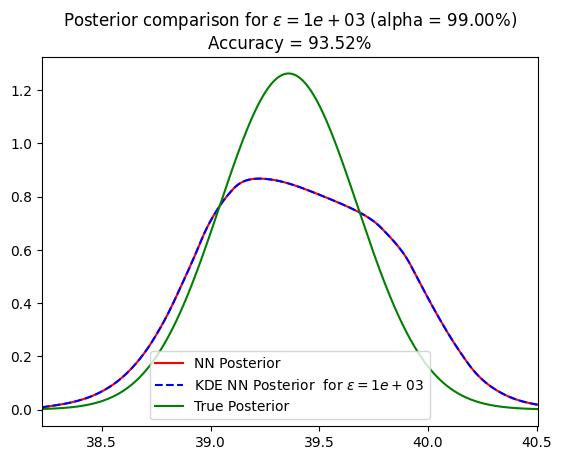

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


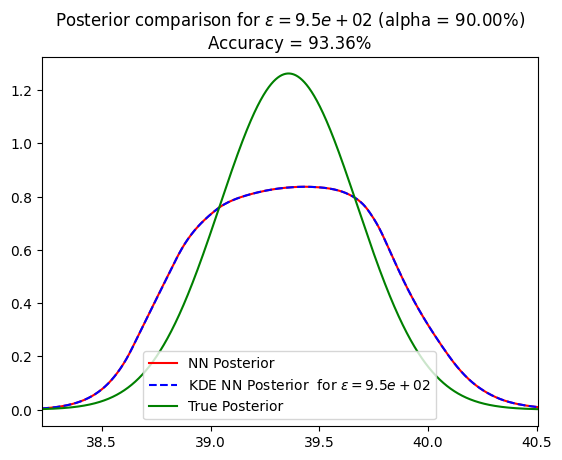

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


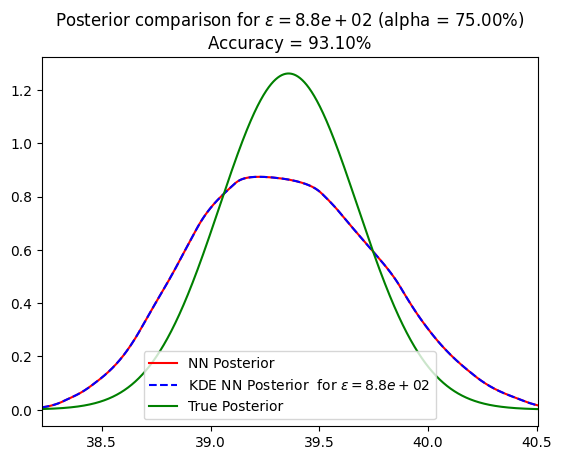

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


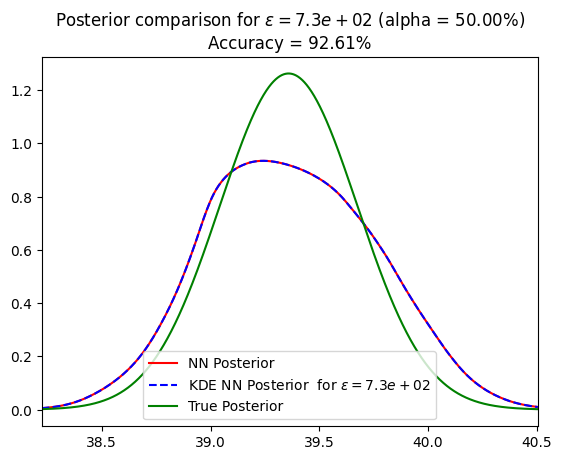

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


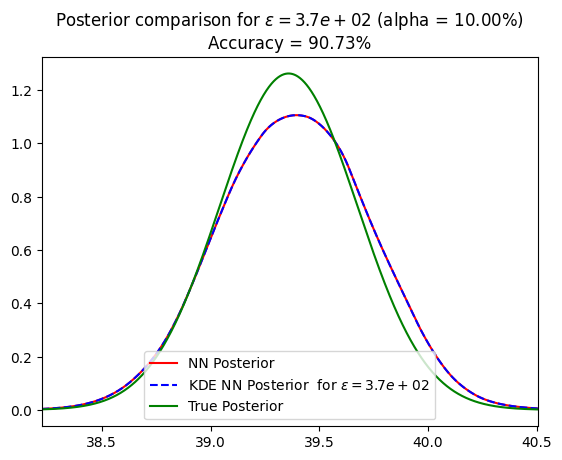

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


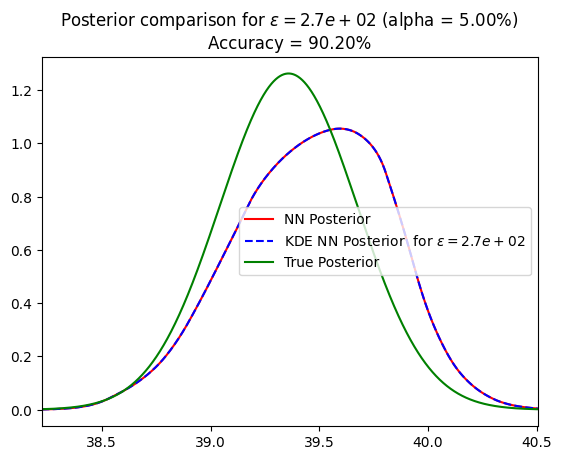

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


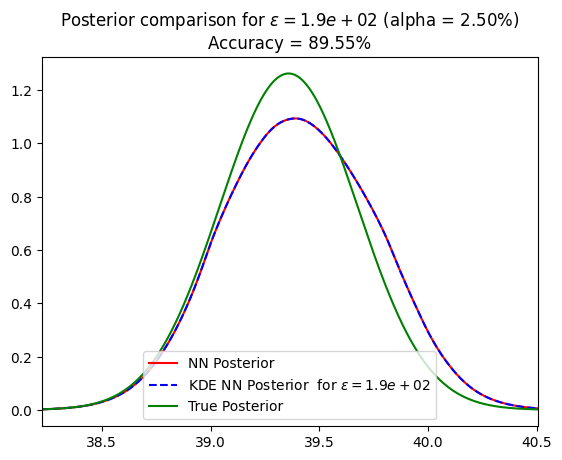

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


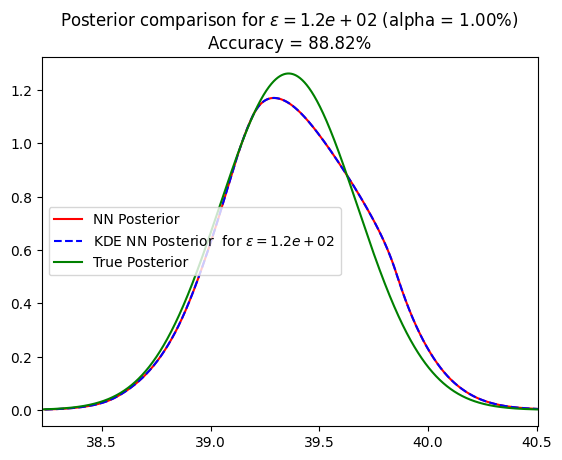

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


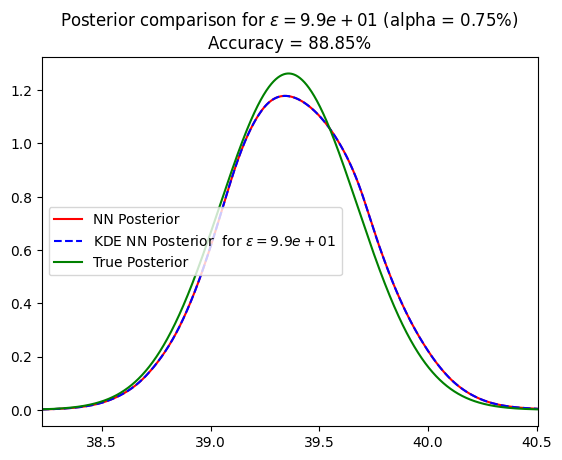

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


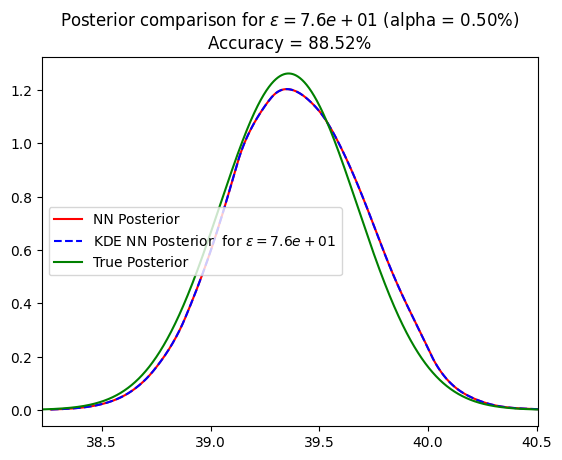

Grid true pseudo posterieure...
Grid NN approx...
Grid KDE NN approx...


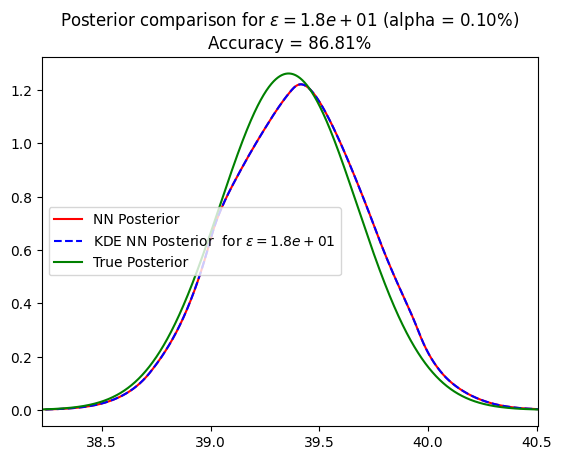

In [151]:
from jax.scipy.stats import norm, gaussian_kde
from functions.SBC import new_post_pdf_z
MINN, MAXX = -100, 100
ACCEPT_RATES = np.sort(list(EPSILONS2.keys()))[::-1]
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
prior_pdf = lambda x: norm.pdf(x, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)
posterior = true_post
likelihood = lambda x: jnp.exp(jnp.sum((x-TRUE_DATA2)**2)/(2*SIGMA**2))
grid_prior, pdf_prior = find_grid_explorative(prior_pdf, 10000, 10000, MINN, MAXX)
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA2).pdf(x), 10000, 10000, MINN, MAXX)
SIGMA0 = 20. 

Z_prior = np.trapz(pdf_prior, grid_prior)
Z_true = np.trapz(pdf_true, grid_true)

for acc in ACCEPT_RATES:
    EPSILON_STAR = EPSILONS2[acc]
    kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA2), EPSILON_STAR, prior)

    params = PARAMS2[acc] 
    print("Grid true pseudo posterieure...")
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA2), EPSILON_STAR, prior), 10000, 10000, MINN, MAXX)
    print("Grid NN approx...")
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA2, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    print("Grid KDE NN approx...")
    grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA2, kde_approx), 10000, 10000, MINN, MAXX)
    Z_pseudo = np.trapz(pdf_pseudo, grid_pseudo)
    Z_nn = np.trapz(pdf_nn, grid_nn)
    Z_kde_nn = np.trapz(pdf_kde_nn, grid_kde_nn)
    
    plt.plot(grid_nn, pdf_nn/Z_nn, label = 'NN Posterior', color = "red")
    plt.plot(grid_kde_nn, pdf_kde_nn/Z_kde_nn, label = f"KDE NN Posterior  for $\epsilon = {EPSILON_STAR:.2}$", color = "blue", linestyle = "--")
    # plt.plot(grid_pseudo, pdf_pseudo/Z_pseudo, label = f"ABC pseudopost for $\epsilon = {EPSILON_STAR:.2}$", color = "orange")
    # plt.plot(grid_prior, pdf_prior/Z_prior, label = 'Prior', color = "grey", linestyle = "--")
    plt.plot(grid_true, pdf_true/Z_true, label = 'True Posterior', color = "green")





    plt.xlim(np.min(grid_true), np.max(grid_true))
    plt.title(f"Posterior comparison for $\epsilon = {EPSILON_STAR:.2}$ (alpha = {acc:.2%})\nAccuracy = {TEST_ACCURACY2[acc]:.2%}")
    plt.legend()
    plt.show()


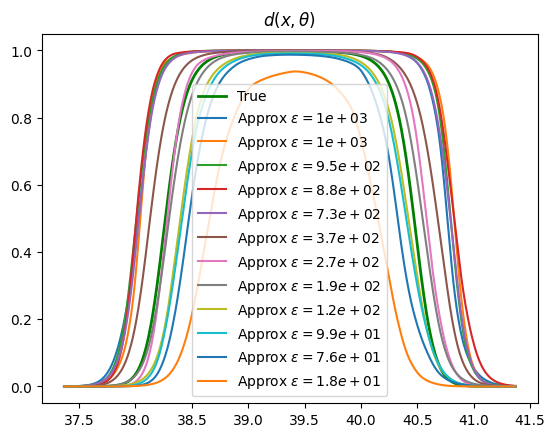

In [144]:
grid = np.linspace(np.mean(TRUE_DATA2)-2, np.mean(TRUE_DATA2)+2, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS2[1.]
true_decision = true_decision_z(grid, TRUE_DATA2, prior, posterior)
plt.plot(grid, true_decision, color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS2[acc]
    epsilon = EPSILONS2[acc]
    approx_decision = 1/(1+jnp.exp(-logratio_batch_z(params, grid, TRUE_DATA2)))
    plt.plot(grid, approx_decision, label = f"Approx $\epsilon = {epsilon:.2}$")
plt.legend()
plt.title("$d(x,\\theta)$")
plt.show()



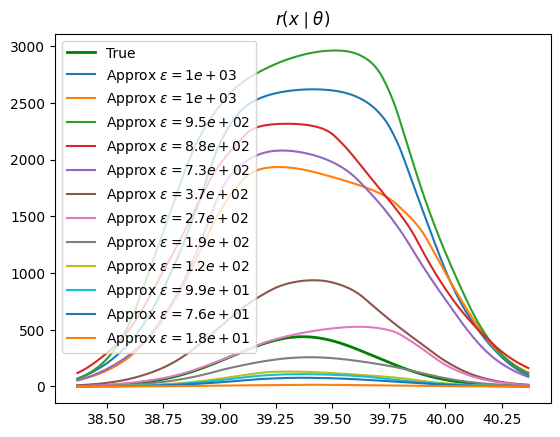

In [152]:
grid = np.linspace(np.mean(TRUE_DATA2)-1, np.mean(TRUE_DATA2)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS2[1.]
true_decision = true_decision_z(grid, TRUE_DATA2, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio, color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS2[acc]
    epsilon = EPSILONS2[acc]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA2))
    plt.plot(grid, approx_ratio, label = f"Approx $\epsilon = {epsilon:.2}$")
plt.legend()
plt.title("$r(x\mid \\theta)$")
plt.show()



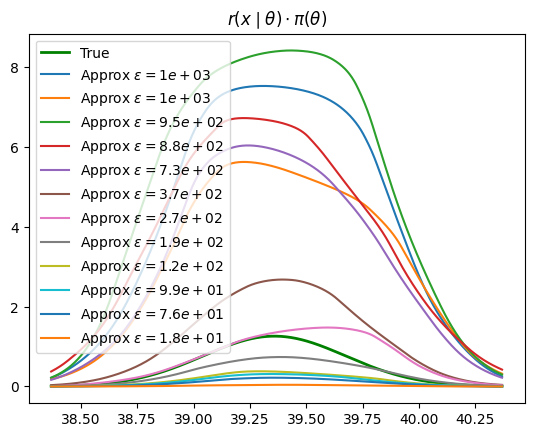

In [153]:
grid = np.linspace(np.mean(TRUE_DATA2)-1, np.mean(TRUE_DATA2)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS2[1.]
true_decision = true_decision_z(grid, TRUE_DATA2, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio*prior.pdf(grid), color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS2[acc]
    epsilon = EPSILONS2[acc]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA2))
    plt.plot(grid, approx_ratio*prior.pdf(grid), label = f"Approx $\epsilon = {epsilon:.2}$")
plt.legend()
plt.title("$r(x\mid\\theta)\cdot \pi(\\theta)$")
plt.show()

Z_true = 0.9984284396403285
Z_approx (for epsilon = 1e+03) = 8.6
Z_approx (for epsilon = 1e+03) = 6.4
Z_approx (for epsilon = 9.5e+02) = 1e+01
Z_approx (for epsilon = 8.8e+02) = 7.6
Z_approx (for epsilon = 7.3e+02) = 6.4
Z_approx (for epsilon = 3.7e+02) = 2.4
Z_approx (for epsilon = 2.7e+02) = 1.4
Z_approx (for epsilon = 1.9e+02) = 0.67
Z_approx (for epsilon = 1.2e+02) = 0.32
Z_approx (for epsilon = 9.9e+01) = 0.26
Z_approx (for epsilon = 7.6e+01) = 0.18
Z_approx (for epsilon = 1.8e+01) = 0.035


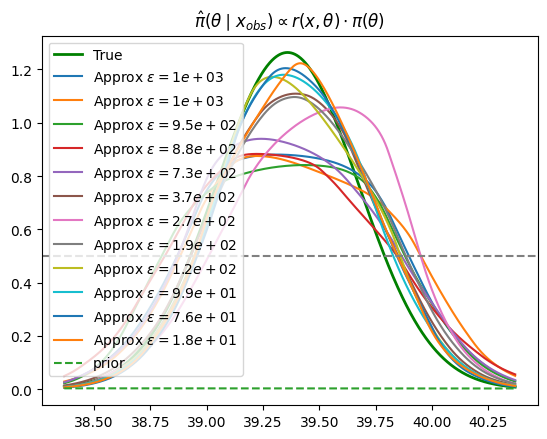

In [155]:
grid = np.linspace(np.mean(TRUE_DATA2)-1, np.mean(TRUE_DATA2)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS2[1.]
true_decision = true_decision_z(grid, TRUE_DATA2, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS2[acc]
    epsilon = EPSILONS2[acc]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA2))
    pseudo = prior.pdf(grid)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    plt.plot(grid,approx/Z_approx, label = f"Approx $\epsilon = {epsilon:.2}$")
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_{obs}) \propto r(x,\\theta)\cdot \pi(\\theta)$")
plt.axhline(0.5, color = "grey", linestyle = "--")
plt.show()

/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_9689/1812100366.py:11: RuntimeWarning: divide by zero encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))
/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_9689/1812100366.py:11: RuntimeWarning: overflow encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))


(28.202817916870117, 30.483049392700195)

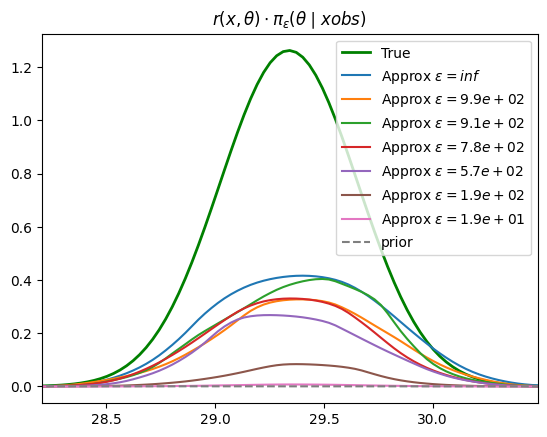

In [ ]:
grid = np.linspace(-100, 200, 10000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
plt.plot(grid,true_postt , color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS[acc]
    epsilon = EPSILONS[acc]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo#/np.trapz(pseudo, grid)
    plt.plot(grid,approx, label = f"Approx $\epsilon = {epsilon:.2}$")
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")

plt.legend()
plt.title("$r(x,\\theta)\cdot \pi_\epsilon(\\theta\mid xobs)$")
plt.xlim(grid_true.min(), grid_true.max())

Z_true = 0.9984284396403285
Z_approx (for epsilon = 1e+03) = 8.6
Z_approx (for epsilon = 1e+03) = 6.4
Z_approx (for epsilon = 9.5e+02) = 1e+01
Z_approx (for epsilon = 8.8e+02) = 7.6
Z_approx (for epsilon = 7.3e+02) = 6.4
Z_approx (for epsilon = 3.7e+02) = 2.4
Z_approx (for epsilon = 2.7e+02) = 1.4
Z_approx (for epsilon = 1.9e+02) = 0.67
Z_approx (for epsilon = 1.2e+02) = 0.32
Z_approx (for epsilon = 9.9e+01) = 0.26
Z_approx (for epsilon = 7.6e+01) = 0.18
Z_approx (for epsilon = 1.8e+01) = 0.035


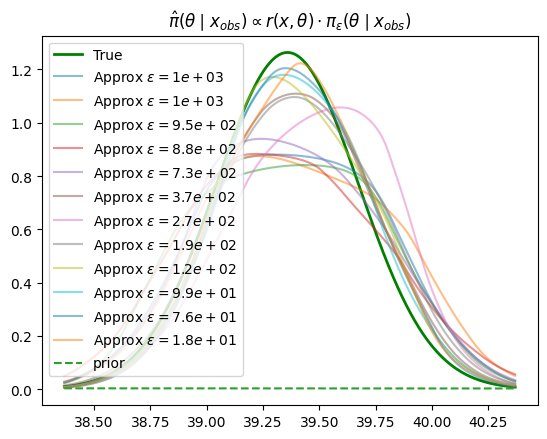

In [149]:
grid = np.linspace(np.mean(TRUE_DATA2)-1, np.mean(TRUE_DATA2)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS2[1.]
true_decision = true_decision_z(grid, TRUE_DATA2, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS2[acc]
    epsilon = EPSILONS2[acc]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA2))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA2),epsilon, prior)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    plt.plot(grid,approx/Z_approx, label = f"Approx $\epsilon = {epsilon:.2}$", alpha = .5)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_{obs}) \propto r(x,\\theta)\cdot \pi_\epsilon(\\theta\mid x_{obs})$")
plt.show()

# Analyse pour $\epsilon = +\infty$

Z_true = 0.98, Z_nn = 1.1


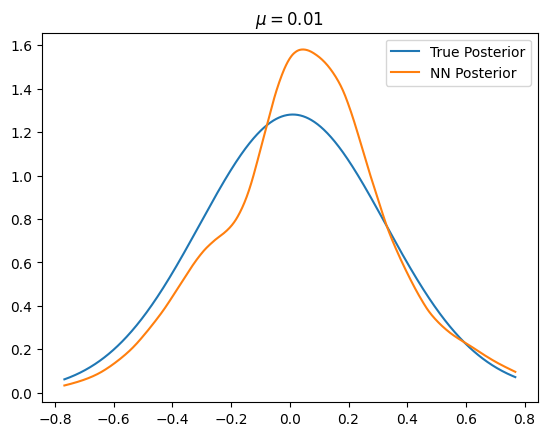

Z_true = 1.0, Z_nn = 1.0


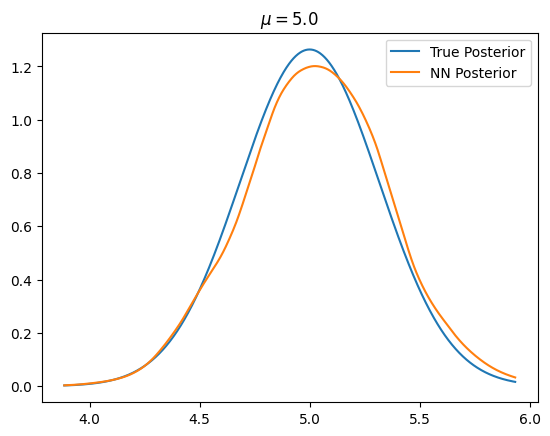

Z_true = 1.0, Z_nn = 1.1


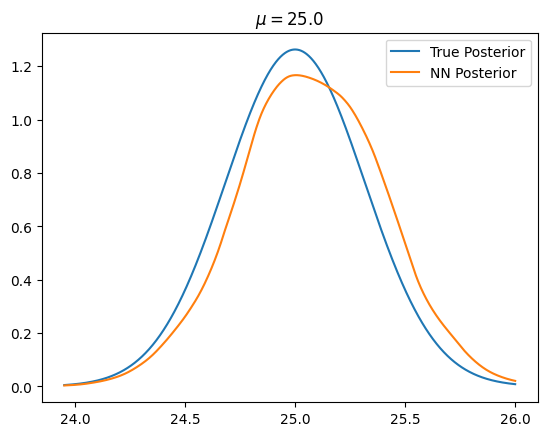

Z_true = 0.98, Z_nn = 0.99


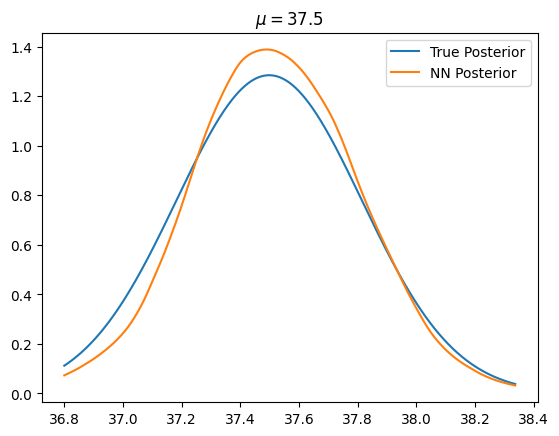

Z_true = 0.98, Z_nn = 1.0


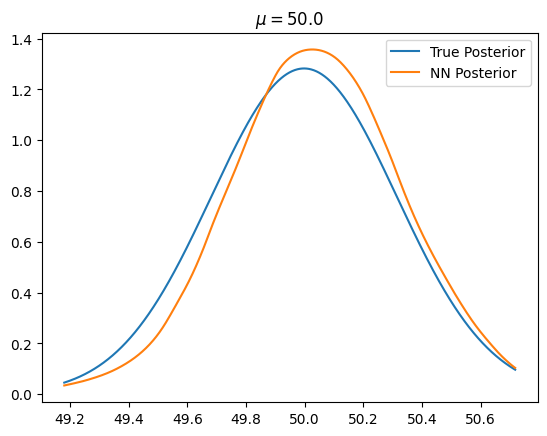

Z_true = 1.0, Z_nn = 0.99


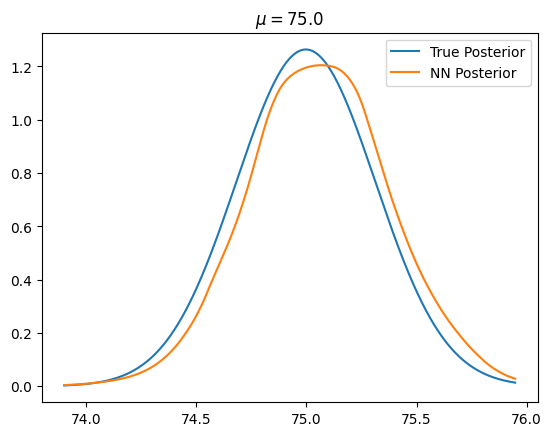

Z_true = 0.98, Z_nn = 0.75


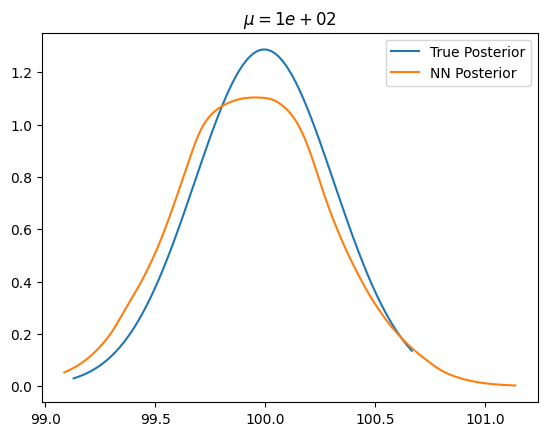

In [ ]:
alpha = .1 
SIGMA0 = 50.
ps = np.linspace(alpha, 1-alpha, 15)
mus = [0.01, .1*SIGMA0, .5*SIGMA0, .75*SIGMA0, SIGMA0, 1.5*SIGMA0, 2*SIGMA0]
Z = stats.norm.rvs(scale = SIGMA, size = N_DATA)
Z = Z - np.mean(Z)
params = PARAMS[1.]
for mu in mus: 
    Z = stats.norm.rvs(scale = SIGMA, size = N_DATA)
    Z = Z - np.mean(Z)
    TRUE_DATA = Z + mu
    grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 1000, 1000, MINN, MAXX)
    Z_true = np.trapz(pdf_true, grid_true)
    plt.plot(grid_true, pdf_true/Z_true, label = f"True Posterior")
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 1000, 1000, MINN, MAXX)
    Z_nn = np.trapz(pdf_nn, grid_nn)
    print(f"Z_true = {Z_true:.2}, Z_nn = {Z_nn:.2}")
    plt.plot(grid_nn, pdf_nn/Z_nn, label = f"NN Posterior ")
    plt.title(f"$\mu = {mu:.3}$")
    plt.legend()
    plt.show()
    

    

# C2ST

In [37]:
from functions.SBC import post_sample, post_sample_batch

In [90]:
from sbibm.metrics import c2st
import torch
from tqdm.notebook import tqdm

In [156]:
C2ST = {}
N_sample = 1000
N_samples = 10
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA2).pdf(x), 1000, 1000, MINN, MAXX)
sample_true = true_post(TRUE_DATA2).rvs(N_sample)
key = random.PRNGKey(0)
for alpha in tqdm(np.sort(list(EPSILONS2.keys()))[::-1]):
    params = PARAMS2[alpha]
    c_alpha = []
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA2, PRIOR_LOGPDF), 1000, 1000, MINN, MAXX)

    for _ in range(N_samples):
        sample_true = true_post(TRUE_DATA2).rvs(N_sample)
        key, subkey = random.split(key)
        nn_sample = post_sample(subkey, grid_nn, pdf_nn, N_sample)
        c_alpha.append(np.array(c2st(torch.tensor(nn_sample[:,None]), torch.tensor(sample_true[:,None])))[0])
    C2ST[alpha] = np.mean(c_alpha)

  0%|          | 0/12 [00:00<?, ?it/s]

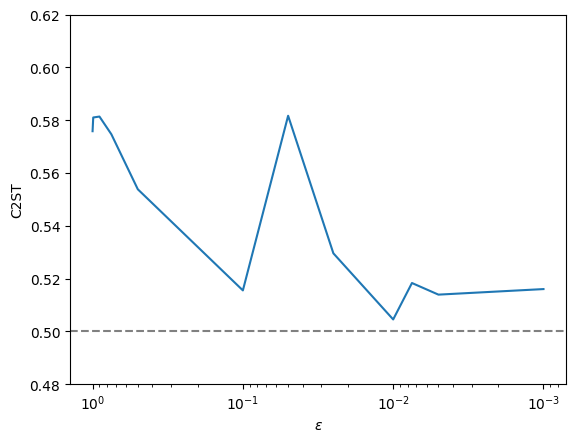

In [157]:
plt.plot(np.sort(list(EPSILONS.keys()))[::-1], list(C2ST.values()))
plt.xlabel("$\epsilon$")
plt.gca().invert_xaxis()
plt.axhline(0.5, color = "grey", linestyle = "--")
plt.ylabel("C2ST")
plt.ylim(0.48,.62)
plt.xscale("log")

In [ ]:
alpha = .001
SIGMA0 = 20.
ps = np.linspace(alpha, 1-alpha, 20)
Z = stats.norm.rvs(scale = SIGMA, size = N_DATA)
Z = Z - np.mean(Z)
mus = stats.norm.ppf(ps, loc = MU0, scale = SIGMA0)

PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
accs = []
key = random.PRNGKey(0)

N_sample = 10000
C2ST = {}
for alpha in np.sort(list(EPSILONS2.keys()))[::-1]:
    params = PARAMS2[alpha]
    EPSILON_STAR = EPSILONS2[alpha]
    for mu in tqdm(mus): 
        Z = stats.norm.rvs(scale = SIGMA, size = N_DATA)
        Z = Z - np.mean(Z)
        TRUE_DATA = Z + mu
        grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 1000, 1000, MINN, MAXX)
        grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 1000, 1000, MINN, MAXX)
        true_sample = true_post(TRUE_DATA).rvs(N_sample)
        key, key_nn = random.split(key)
        nn_sample = post_sample(key_nn, grid_nn, pdf_nn, N_sample)
        
        accuracy = c2st(torch.tensor(true_sample[:,None]), torch.tensor(nn_sample[:,None]))
        accs.append(np.array(accuracy)[0])
    

ValueError: x and y must have same first dimension, but have shapes (1000000, 1) and (100,)

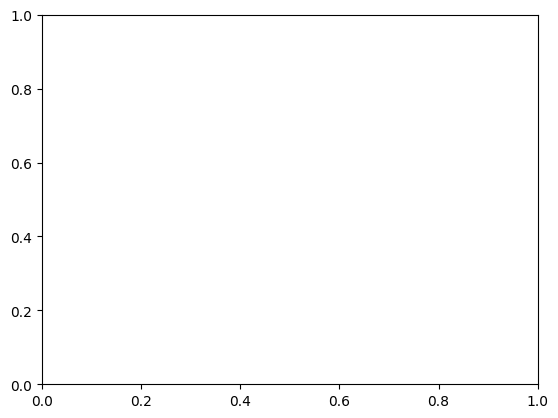

In [87]:
plt.plot(mus, accs)

In [67]:
true_sample = true_post(TRUE_DATA).rvs(10000)
key = random.PRNGKey(0)
true_sample2 = true_post(TRUE_DATA).rvs(10000)
acc = c2st(torch.tensor(true_sample[:,None]), torch.tensor(true_sample2[:,None]))
print(acc)


tensor([0.5005])


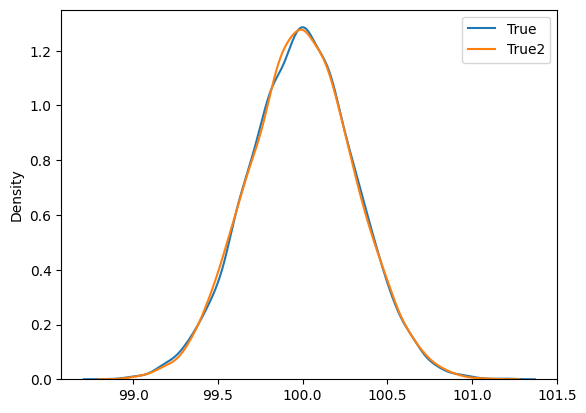

In [66]:
sns.kdeplot(true_sample, label = "True")
sns.kdeplot(true_sample2, label = "True2")
plt.legend()